In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
print(tf.__version__)

In [6]:
batch_size = 32
img_height = 128
img_width = 128

directory = os.path.join(os.getcwd(),"data", "training")

In [7]:
training_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split = 0.2, #20% of data is used for training and validation
    subset = "training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split = 0.2, #20% of data is used for testing results
    subset = "validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 15244 files belonging to 9 classes.
Using 12196 files for training.
Found 15244 files belonging to 9 classes.
Using 3048 files for validation.


In [8]:
class_names = training_ds.class_names
print(f"Categories: {class_names}")

Categories: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes']


In [ ]:
plt.figure(figsize=(10,10))

for images, labels in training_ds.take(1): #takes one batch of 32
    for i in range(9): 
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [ ]:
#without augmentation the model was overfitting even getting worse on 
# validation data with loss doubling from epoch 3 to epoch 10

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) # Show 9 variations of same img
        plt.axis("off")
plt.show()

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    #layer0 makes training harder by using augmentation
    data_augmentation,

    #Layer 1: Rescaling
    tf.keras.layers.Rescaling(1./255),
    #LAyer2 : Kernel/Feature Finder
    tf.keras.layers.Conv2D(16,3, padding="same", activation="relu"),
    #Layer 3: Compressor (Shrinks feature maps from kernel)
    tf.keras.layers.MaxPooling2D(),

    #layer 4 & 5 (more filters for more complex patterns)
    tf.keras.layers.Conv2D(32,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    #lyer 6: flatten
    tf.keras.layers.Flatten(),

    #layer 7: Dense 128 Neurons("make sense" of flattened list)
    tf.keras.layers.Dense(128,activation="relu"),
    #layer 8: outputs 8 numbers (highest number is models guess)
    tf.keras.layers.Dense(num_classes)
])

model.summary()

In [ ]:
#adam is teacher that adjusts weights and biases, loss is grading scale for accuracy
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)

In [ ]:
epochs = 40

history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy ({epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot4(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Training and Validation Loss ({epochs} epochs)')

plt.show()

In [ ]:
# Run 4 (bigger model, added batchnormalization and more layers)

num_classes = len(class_names)

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    
    tf.keras.layers.Conv2D(32, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(512, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(num_classes)
])


In [ ]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)

epochs = 100
history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs
)

In [ ]:
# 3. Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy ({epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Training and Validation Loss ({epochs} epochs)')

plt.show()

In [ ]:
model_filename = 'sorti_model_87valacc.keras'
model.save(model_filename)

In [9]:
#CREATING CONFUSION MATRIX

import numpy as np

loaded_model = tf.keras.models.load_model('sorti_87valacc_run4.keras')

y_true = []
y_pred = []

for images, labels in validation_ds:
    predictions = loaded_model.predict(images, verbose=0)

    #argmax to pick index of highest number
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

     battery       0.88      0.72      0.79       163
  biological       0.91      0.68      0.78       155
   cardboard       0.82      0.94      0.88       404
     clothes       0.90      0.92      0.91       408
       glass       0.88      0.86      0.87       497
       metal       0.70      0.89      0.78       269
       paper       0.83      0.89      0.86       386
     plastic       0.91      0.73      0.81       464
       shoes       0.87      0.87      0.87       302

    accuracy                           0.85      3048
   macro avg       0.85      0.83      0.84      3048
weighted avg       0.86      0.85      0.85      3048



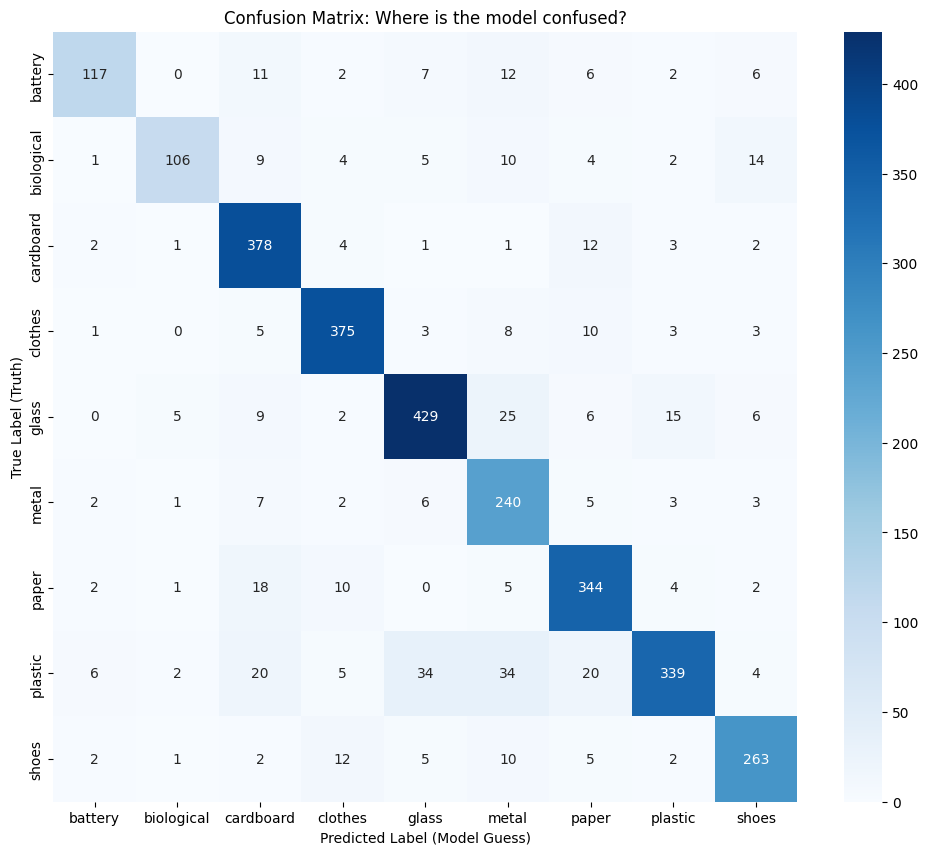

In [13]:
# 1. Calculate the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 2. Plot it as a Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix: Where is the model confused?')
plt.ylabel('True Label (Truth)')
plt.xlabel('Predicted Label (Model Guess)')
plt.show()